In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from radiomics import featureextractor, getTestCase

In [2]:
image_viewer = sitk.ImageViewer()

In [3]:
#slicer = 'D:/Users/maryskal/Slicer 5.0.2/Slicer.exe'
slicer = '/home/maryskal/Slicer/Slicer'
image_viewer.SetApplication(slicer)

In [4]:
ctFolder = 'Vessel_stencils'
ctPath = os.path.join(ctFolder,'10047G_INSP_STD_BWH_COPD.nrrd')
maskPaths = ['mask__lt5_artery_2.nrrd', 'mask__lt5_artery_5.nrrd', 'mask_full_artery_3.nrrd']
maskPaths = [os.path.join(ctFolder, '10047G_INSP_STD_BWH_COPD', mask) for mask in maskPaths]

In [5]:
ct = sitk.ReadImage(ctPath)
masks = {}
for maskPath in maskPaths:
    masks[maskPath[-18:-5]] = sitk.ReadImage(maskPath)

In [6]:
extractor = featureextractor.RadiomicsFeatureExtractor()
extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')
extractor.enableFeatureClassByName('glrlm')
extractor.enableFeatureClassByName('ngtdm')
extractor.enabledFeatures

{'firstorder': [], 'glrlm': [], 'ngtdm': []}

### Extracción

In [7]:
features_dict = {}
for k, mask in masks.items():
    result = extractor.execute(ct, mask)
    feature_names = list(sorted(filter(lambda k: k.startswith("original_"), result)))
    features_dict[k] = {}
    for feature in feature_names:
        features_dict[k][feature] = float(result[feature])

In [8]:
features_dict

{'_lt5_artery_2': {'original_firstorder_10Percentile': -931.0,
  'original_firstorder_90Percentile': -739.0,
  'original_firstorder_Energy': 3182050922227.0,
  'original_firstorder_Entropy': 3.5844123458266486,
  'original_firstorder_InterquartileRange': 91.0,
  'original_firstorder_Kurtosis': 15.78732610572031,
  'original_firstorder_Maximum': 339.0,
  'original_firstorder_Mean': -846.918642324047,
  'original_firstorder_MeanAbsoluteDeviation': 65.7187542754502,
  'original_firstorder_Median': -871.0,
  'original_firstorder_Minimum': -1024.0,
  'original_firstorder_Range': 1363.0,
  'original_firstorder_RobustMeanAbsoluteDeviation': 39.1982589590297,
  'original_firstorder_RootMeanSquared': 852.365820598492,
  'original_firstorder_Skewness': 2.6551252464011386,
  'original_firstorder_TotalEnergy': 613750412948.1064,
  'original_firstorder_Uniformity': 0.11086712861397556,
  'original_firstorder_Variance': 9256.30540853344,
  'original_glrlm_GrayLevelNonUniformity': 385051.5720438382,


Union de los dos resultados

In [9]:
# lista de cada uno de los diccionarios
dict_list = [features for features in features_dict.values()]
# unifico los diccionarios (mismas claves, lista de valores)
features = {}
for k, v in dict_list[0].items():
    features[k] = [dic[k] for dic in dict_list]

In [10]:
df = pd.DataFrame(features)
# NORMALIZO
for column in df.columns:
    df[column] = abs(df[column] /df[column].abs().max())
# Añado la mascara
df['type_mask'] = masks.keys()

In [11]:
df

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,type_mask
0,0.990426,0.940204,0.217090,1.000000,1.000000,0.480596,0.261978,0.980801,0.996647,0.975364,...,0.393769,1.000000,0.935140,0.928734,0.460355,1.000000,0.328995,1.000000,0.409209,_lt5_artery_2
1,1.000000,1.000000,1.000000,0.928890,0.703297,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.902925,1.000000,0.991674,1.000000,0.244316,1.000000,0.362893,1.000000,_lt5_artery_5
2,0.997872,0.980916,0.462177,0.948861,0.791209,0.870623,0.620556,0.999016,0.929409,0.993281,...,0.696301,0.938768,0.851731,1.000000,0.598260,0.523351,0.638440,0.425820,0.903719,full_artery_3


In [12]:
firstorder = [col for col in df.columns if bool(re.search('firstorder', col))]
glrlm = [col for col in df.columns if bool(re.search('glrlm', col))]
ngtdm = [col for col in df.columns if bool(re.search('ngtdm', col))]

In [13]:
list(masks.keys())

['_lt5_artery_2', '_lt5_artery_5', 'full_artery_3']

## First order comparation

_lt5_artery_2
_lt5_artery_5
full_artery_3


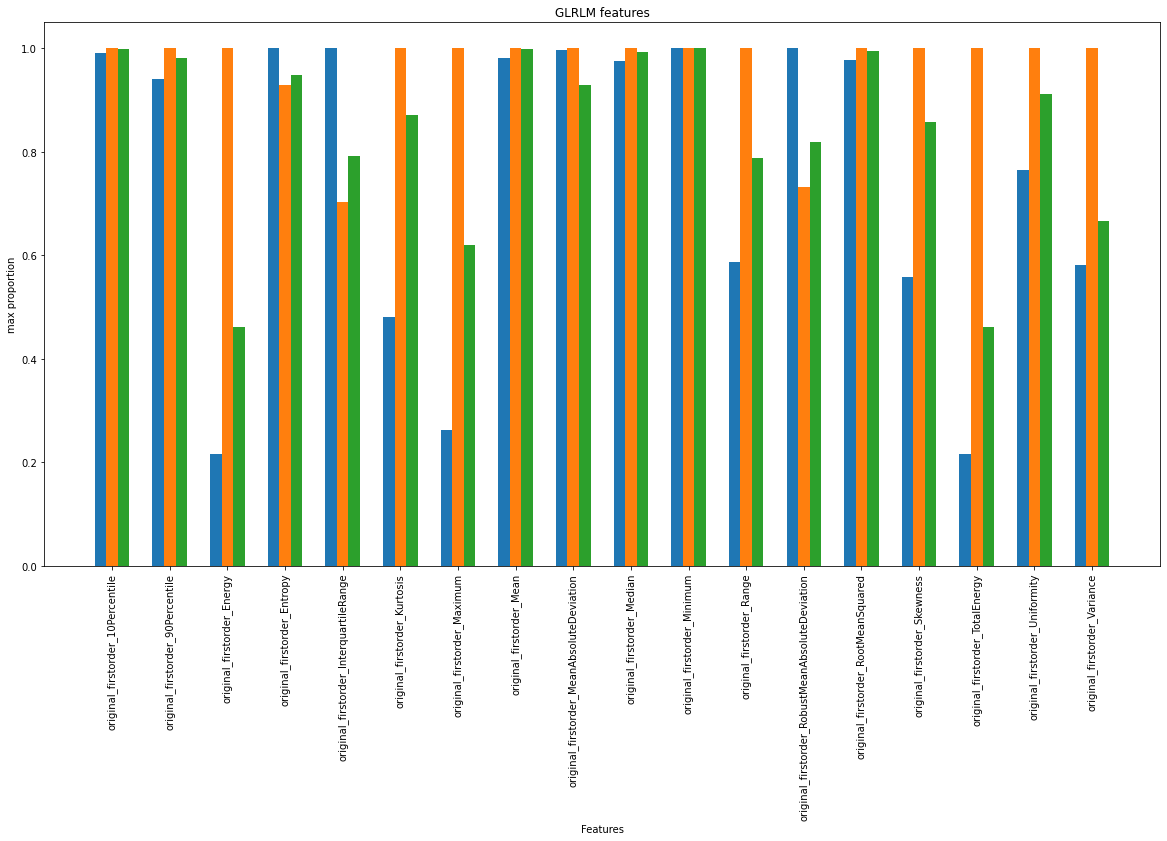

In [14]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = firstorder
X_axis = np.arange(len(X))
axis = [-0.2,0, 0.2]

for i in range(3):
    print(list(masks.keys())[i])
    plt.bar(X_axis+axis[i], df[firstorder].iloc[i], 0.2, label = list(masks.keys())[i])

plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("GLRLM features")
plt.show()

## GLRLM comparation

_lt5_artery_2
_lt5_artery_5
full_artery_3


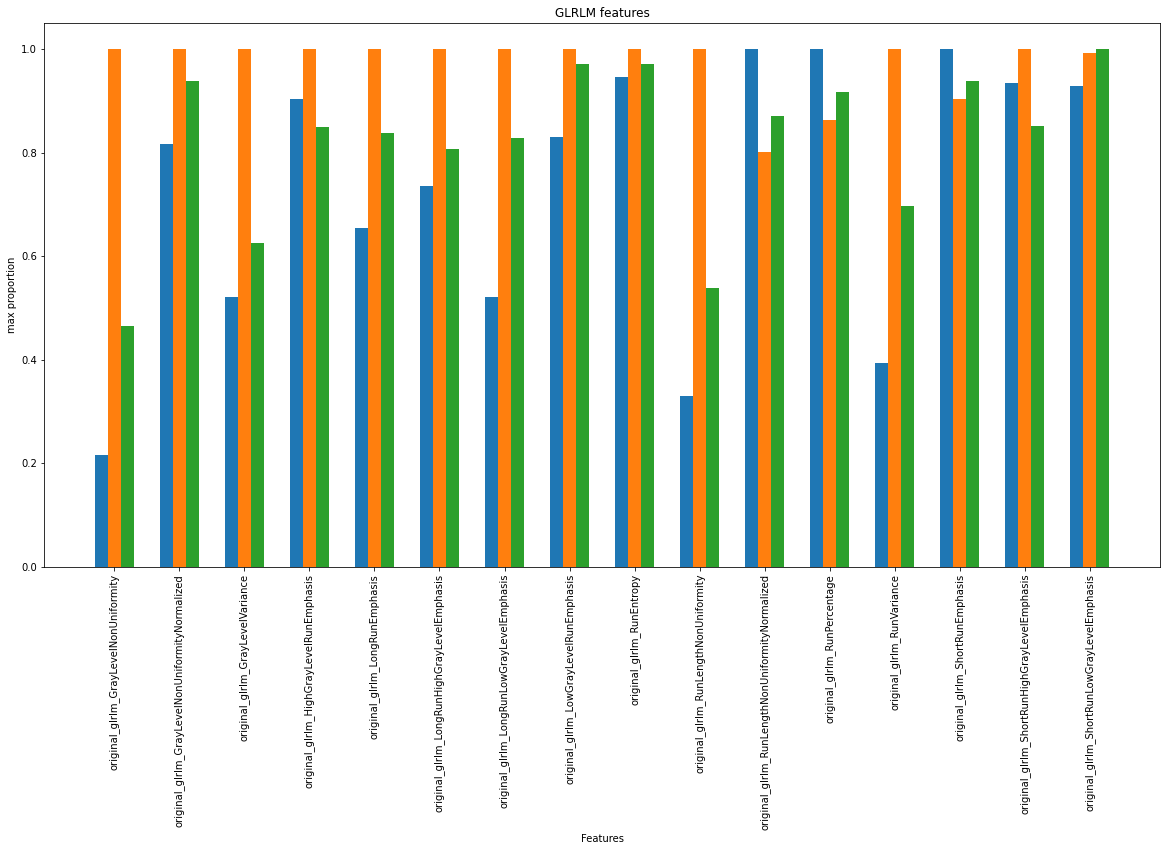

In [15]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = glrlm
X_axis = np.arange(len(X))
axis = [-0.2,0, 0.2]

for i in range(3):
    print(list(masks.keys())[i])
    plt.bar(X_axis+axis[i], df[glrlm].iloc[i], 0.2, label = list(masks.keys())[i])

plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("GLRLM features")
plt.show()

## NGTDM comparation

_lt5_artery_2
_lt5_artery_5
full_artery_3


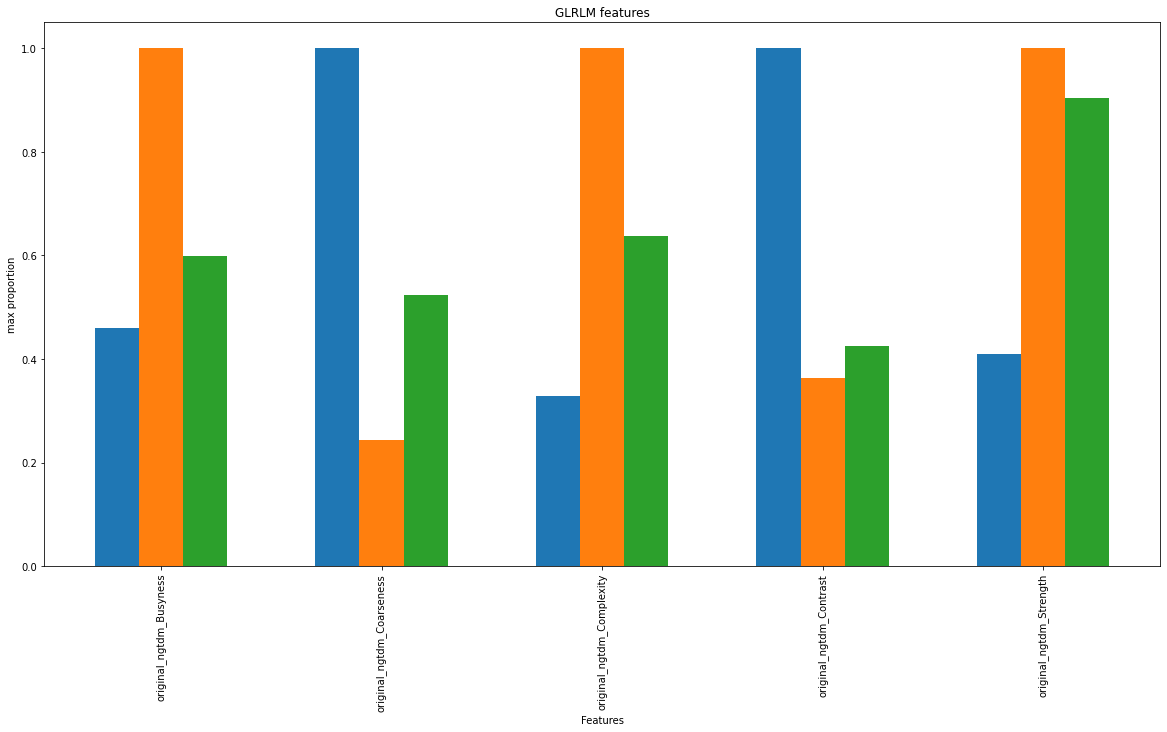

In [16]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)

X = ngtdm
X_axis = np.arange(len(X))
axis = [-0.2,0, 0.2]

for i in range(3):
    print(list(masks.keys())[i])
    plt.bar(X_axis+axis[i], df[ngtdm].iloc[i], 0.2, label = list(masks.keys())[i])

plt.xticks(X_axis, X)
plt.xlabel("Features")
plt.ylabel("max proportion")
plt.title("GLRLM features")
plt.show()